# Tutorial 03 - Velocity inversion
Starting out by importing the relevant modules we'll need for this exercise:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pestoseis.ttimerays as tr

## 1. Problem Setup
The objective of this exercise is to retrieve the velocity model for the given traveltimes.  In other words, we want to solve the inverse problem of finding the structure of the Earth from some set of observed measurements.

In [2]:
i = 3 # 1 2 3

In [3]:
filename = 'inputdata/exe3_input_model_{}.npy'.format(i)
print(filename)

inputdata/exe3_input_model_3.npy


In [4]:
inpdat=np.load(filename,allow_pickle=True).item()
gridpar=inpdat['gridpar']
sources=inpdat['srcs']
receivers=inpdat['recs']
bkgttimegrd=inpdat['bkgttimegrd']
bkgttpick=inpdat['bkgttpick']
cov_m=inpdat['cov_m']
cov_d=inpdat['cov_d']
mprior=inpdat['mprior']
residuals=inpdat['residuals']

## 2. Trace Ray Paths
Trace the rays in the given background velocity model.  This background velocity model serves as a first _guess_ of the structure of the subsurface.  This model is used to _fix_ the path of the rays, but not the velocity structures within the domain.  The subsequent inversion process will refine the velocity structures that we see in the domain.

In [5]:
rays = tr.traceallrays(gridpar,sources,receivers,bkgttimegrd)

tracing rays for source 23 of 23     


## 3. Build the Tomography Matrix
To compute the inverse problem, we need to construct a tomography matrix that we can use as an input into the least-squares solver.

In [6]:
tomomat,residualsvector = tr.buildtomomat(gridpar, rays, residuals)

Building forward matrix


## 4. Perform the Least-Squares Inversion
This step performs the actual inversion using a least-squares solver.  The objective function of this inverse problem is defined as<br>
<br>
$$
    S(\mathbf{m}) = \frac{1}{2} \left( \mathbf{G} \mathbf{m} - \mathbf{d}_\text{obs} \right)^\intercal \mathbf{C}_\text{D}^{-1} \left( \mathbf{G} \mathbf{m} - \mathbf{d}_\text{obs} \right) + \frac{1}{2} \left( \mathbf{m} - \mathbf{m}_\text{prior} \right)^\intercal \mathbf{C}_\text{M}^{-1} \left( \mathbf{m} - \mathbf{m}_\text{prior} \right).
$$<br>
<br>
Furthermore, the posterior covariance matrix is given by<br>
<br>
$$
    \tilde{\mathbf{C}}_\text{M} = \left( \mathbf{G}^\intercal \mathbf{C}_\text{D}^{-1} \mathbf{G} + \mathbf{G}_\text{M}^{-1} \right)^{-1}
$$<br>
<br>
and the center of the posterior Gaussian (the mean model) is given by<br>
<br>
$$
    \tilde{\mathbf{m}} = \mathbf{m}_\text{prior} + \tilde{\mathbf{C}}_\text{M} \mathbf{G}^\intercal \mathbf{C}_\text{D}^{-1} \left(\mathbf{d}_\text{obs} - \mathbf{G} \mathbf{m}_\text{prior} \right).
$$<br>
<br>
These computations are handled internally when executing `lininv()` within the `pestoseis.ttimerays` submodule.

In [7]:
postm,postC_m = tr.lininv(tomomat,cov_m,cov_d,mprior,residualsvector)

Computing posterior mean model and covariance...


## 5. Plotting the Results

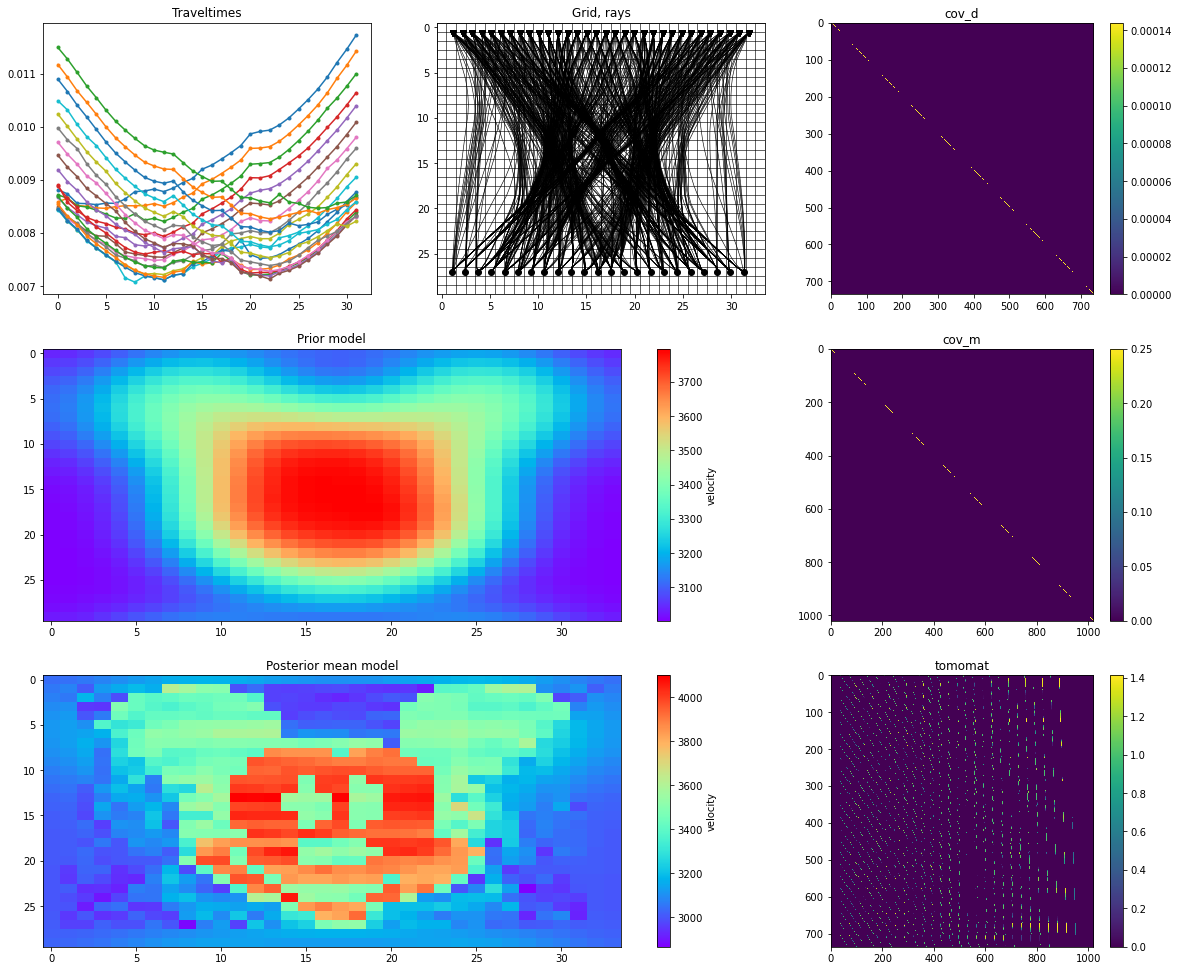

In [8]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(20,17))
cmap = plt.cm.jet
gs = gridspec.GridSpec(3, 3)
plt.subplot(gs[0, 0]) 
plt.title('Traveltimes')
for i in range(residuals.size):
    plt.plot(residuals[i][:],'.-')#,label='src {}'.format(i))
    #plt.plot(bkgttpick[i][:],'-')
    #plt.plot(ttpickmat[i*nrec:(i+1)*nrec],'-k')
#plt.legend()

plt.subplot(gs[0,1])
plt.title('Grid, rays')
tr.plotrays(sources,receivers,rays)
tr.plotgrid(gridpar)

plt.subplot(gs[1,:2])
plt.title('Prior model')
tr.plotvelmod(gridpar,1.0/tr.rollmod(mprior,gridpar['nx'],gridpar['ny']))
#tr.plotrays(sources,receivers,rays)

plt.subplot(gs[2,:2])
plt.title('Posterior mean model')
tr.plotvelmod(gridpar,1.0/tr.rollmod(postm,gridpar['nx'],gridpar['ny']))
#tr.plotrays(sources,receivers,rays)

plt.subplot(gs[0,2])
plt.title('cov_d')
plt.imshow(cov_d,interpolation='nearest',aspect='auto')
plt.colorbar()

plt.subplot(gs[1,2])
plt.title('cov_m')
plt.imshow(cov_m,interpolation='nearest',aspect='auto')
plt.colorbar()

plt.subplot(gs[2,2])
plt.title('tomomat')
plt.imshow(tomomat,interpolation='nearest',aspect='auto')
plt.colorbar()

# plt.figure()
# ref= np.load('refmod_lowres.npy')
# plotvelmod(gridpar,ref)
plt.show()

In the above plots we can see the how we were able to take a fairly rough starting model (containing a pretty approximate estimate of the shape of the model) and then refined this within the subsequent inversions.

  Try to re-run the notebook with different value of `i`. i.e., with different input datasets.